# Meeresspiegelsimulation (Copernicus DEM, GLO-30)

**Autor*in:** Julian Hausmann
**Copyright:** © 2025 Urbetho CF GmbH
**Lizenz:** Dieses Notebook steht unter der [CC BY-NC-SA 4.0 License](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en).

<div style="text-align: right"><i> Anfänger*innen </i></div>

In diesem Notebook stellen wir über einen Keycloak-Token und mithilfe der requests Bibliothek und dem OData-Protokoll Zugang zum CODE-DE Datenarchiv her. Wir verwenden das hochauflösende Copernicus DEM (GLO-30) mit einer räumlichen Auflösung von 30m. Die Daten werden über der ostfriesischen Küste in Deutschland heruntergeladen und lokale gespeichert. Auf der Grundlage dieser Daten wird anschließend eine Simulation des Meeresspiegelanstiegs durchgeführt. Letztere findet bereits seit Beginn der Industrialisierung auf Grund steigender globaler Temperaturen statt. Laut [**IPCC**](https://www.geomar.de/entdecken/meeresspiegel) könnte der Meeresspsiegel bis 2300 bis zwischen 0.5m und 15m ansteigen (in Abhängigkeit von den Treibhausgasemissionen). Für moderate Prognosen ist die hohe Auflösung des Copernicus DEM (GLO-30) besonders nützlich, da Dämme und Deiche in die Analyse miteinbezogen werden können. Die Simulation erfolgt schließlich lediglich für einen kleinen Bildausschnitt für die Insel Norderney, um Rechenleistung zu reduzieren.

**General Note 1**: Ausführung der Zellen durch pressen des <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button vom top MENU (oder `Shift` + `Enter`).

**General Note 2**: Falls der Kern nich mehr arbeitet, im the top MENU, klicke <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Dann, im top MENU, clicke  "Run" aund wähle "Run All Above Selected Cell".

**General Note 3**: Schauen Sie sich im [**FORUM**](https://forum.code-de.org/de/) um oder Kontaktieren Sie den Support! 
<br>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/1880-_Global_average_sea_level_rise_%28SLR%29_-_annually.svg/1920px-1880-_Global_average_sea_level_rise_%28SLR%29_-_annually.svg.png">
     
*Die Abbildung zeigt den globalen Meeresspiegelansteig seit 1880 und wurde von der U.S. Environmental Protection Agency (EPA) auf der Grundlage von Daten der CSIRO 2017 und NOAA 2022 erstellt.*

#### 1. Installieren benötigter Bibliotheken 

Verschiedene Pakete müssen installiert werden, bevor Download und Analyse der Daten gestartet werden können. Die Liste der zu installierenden Bibliotheken ist abhängig von den bereits lokal installierten Bibliotheken und muss dementsprechend erweitert werden, falls Bedarf besteht.

In [8]:
!pip install numpy rasterio matplotlib tqdm requests

Defaulting to user installation because normal site-packages is not writeable


#### 2. Importieren der benötigten Bibliotheken

Viele der unten genannten Bibliotheken mussten nicht installiert werden, weil sie entweder bereits installiert wurden oder zu einer generellen Installation von Python zugehörig sind. Ohne die Bibliotheken ist das folgende Skript nicht ausführbar.  

In [9]:
# Versuche die benötigten Pakete zu installieren
try:
    # Liste aller benötigter Pakete
    import requests
    import json
    import time
    from IPython.display import clear_output
    import zipfile
    import os
    import matplotlib.pyplot as plt
    import rasterio
    import numpy as np
    from rasterio.windows import Window
    import matplotlib.dates as mdates
    from tqdm import tqdm
    import glob
    from rasterio import plot
    from scipy.ndimage import binary_propagation
    import numpy as np
    import rasterio
    import matplotlib.pyplot as plt
    from rasterio.windows import Window
    from matplotlib.patches import Polygon
    import getpass

    # Text Ausgabe
    print("Erfolgreiche Installation aller benötigter Pakete.")

except:

    # Text Ausgabe
    print("Nicht erfolgreiche Installation aller benötigter Pakete")

Erfolgreiche Installation aller benötigter Pakete.


#### 3. Erstellen des Keycloak-Token

Für das Herunterladen von CODE-DE Datensätzen benötigen Sie ein Autorisierungs-Token (Keycloak-Token), da nur autorisierte Benutzer Erdbeobachtungsdatenprodukte herunterladen dürfen. Sie werden ein autorisierter Benutzer, wenn sie sich auf www.code-de.org anmelden. In diesem Abschnitt generieren wir diesen Token und weisen ihn der Variable access_token zu, die dann im folgenden Skript mehrfach verwendet wird. Bitte geben Sie ihren eigenen Benutzernamen und das korrespondierende Passwort ein.

Mehr Informationen zum Erstellen des Keycloak-Token erhalten Sie in der CODE-DE [**Knowledge Base**](https://knowledgebase.code-de.org/de/latest/eodata/Using-curl-and-wget-to-download-EODATA-products-from-CODE-DE.html#beziehen-des-keycloak-tokens).

In [11]:
# Authentifizierungsparameter
client_id = "catalog-public"
grant_type = "password"
url = "https://auth.fra1-1.cloudferro.com/auth/realms/code-de/protocol/openid-connect/token"

# Benutzer zur Eingabe der Anmeldedaten auffordern
username = input('Benutzername: ')
password = getpass.getpass('Passowort: ')

# Anforderungsheader (benötigt für das Absenden von Formulardaten)
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
}

# Nutzdaten für die Authentifizierungsanforderung
data = {
    "grant_type": grant_type,
    "username": username,
    "password": password,
    "client_id": client_id
}

try:
    # Sende die POST-Anforderung an den Authentifizierungs-Endpunkt
    response = requests.post(url, data=data)

    # Überprüfen, ob die Authentifizierungsanforderung erfolgreich war
    if response.status_code == 200:

        # JSON-Antwort parsen, um das Zugriffstoken zu extrahieren
        token_data = response.json()
        access_token = token_data.get("access_token")

        # Erfolgsnachricht, wenn das Token empfangen wurde
        if access_token:
            print("Zugriffstoken empfangen.")

        # Fehlermeldung, wenn das Token nicht empfangen wurde
        else:
            print("Zugriffstoken nicht in der Antwort gefunden.")

    # Fehlermeldung für eine nicht erfolgreiche Anfrage
    else:
        print(f"Fehler beim Abrufen des Tokens. Status-Code: {response.status_code}")
        print(response.text)

# Fehlerbehandlung für alle Ausnahmen, die während der Anfrage auftreten
except Exception as e:
    print(f"Es ist ein Fehler aufgetreten: {e}")

Benutzername: julian.hausmann@uni-bonn.de
Passowort: ········
Zugriffstoken empfangen.


#### 4. Erstellen einer API-URL mithilfe des OData-Protokoll

Das OData-Protokoll ist eine standardisierte Möglichkeit, um auf Daten über HTTP zuzugreifen, sie zu filtern und zu manipulieren. Es wird häufig verwendet, um auf geospatiale und andere komplexe Datensätze zuzugreifen, wie im Fall von CODE-DE, einer Plattform für Geodaten.

In diesem Schritt definieren wir eine API-URL, die uns eine Liste von Copernicus DEM (GLO-30)-Daten liefert, die speziell zu den Koordinaten für Norderney passen. Diese Daten sind für die weitere Analyse und Visualisierung von Höhenmodellen wichtig.

Mehr Informationen dazu, wie mit dem OData-Protokoll gearbeitet werden kann, um auf CODE-DE auf Daten zu zugreifen wird in der [**Knowledge Base**](https://knowledgebase.code-de.org/de/latest/eodata/EOData-Catalogue-API-Manual-on-CODE-DE.html#id1) erklärt. Dort wird auch auf ein anderes Protokoll, das OpenSearch-Protokoll eingegangen, dass ebenfalls verwendet werden kann, um auf CODE-DE Daten zuzugreifen.

In [3]:
# Koordinaten von Norderney
longitude = "7.147279"
latitude = "53.705789"

# Definieren der API-URL
base_url = "https://datahub.code-de.org/odata/v1/Products"
api_url = f"{base_url}?$filter=((Online%20eq%20true)%20and%20(OData.CSC.Intersects(Footprint=geography%27SRID=4326;POINT%20({longitude}%20{latitude})%27))%20and%20(((((Collection/Name%20eq%20%27COP-DEM%27)%20and%20(((Attributes/OData.CSC.StringAttribute/any(i0:i0/Name%20eq%20%27productType%27%20and%20i0/Value%20eq%20%27DGE_30%27)))))))))&$expand=Attributes&$expand=Assets&$orderby=ContentDate/Start%20asc&$top=20"

# Sende eine GET-Anfrage an die API
response = requests.get(api_url)

# Überprüfe, ob die Anfrage erfolgreich war (Status-Code 200)
if response.status_code == 200:
    # Parsen der JSON-Daten aus der Antwort
    data = response.json()
    print("API-URL definiert.")
else:
    print("Fehler beim Abrufen der Daten. Status-Code:", response.status_code)
    print("Antwortinhalt:", response.text)

API-URL definiert.


#### 5. Erstellen einer Liste von Satellitenbildern 

Im folgenden soll die auf dem OData-Protokoll basierende API-URL genutzt werden, um eine Liste von Copernicus DEM (GLO-30)-Datensätzen zu erstellen. In diesem Fall wird die Liste nur einen Datensatz enthalten, da dies durch die Nutzer*in festgelegt wurde. Die fertige Liste wird anschließend als Text ausgabe angezeigt.

In [4]:
# Sende die GET-Anfrage an die API, um eine Liste von Copernicus DEM (GLO-30)-Szenen zu erhalten
response = requests.get(api_url)

# Überprüfe, ob die Anfrage erfolgreich war (Status-Code 200)
if response.status_code == 200:

    # Parsen der Antwort im JSON-Format
    data = response.json()
    print("Anfrage wurde erfolgreich gesendet.")

# Fehlermeldung ausgeben, wenn die Antwort nicht erfolgreich war
else:
    print(f"Fehler beim Abrufen der Sammlung. Status-Code: {response.status_code}")
    print(f"Antwortinhalt:", response.text)

# Erstelle eine neue Liste, um die Namen der gewünschten Sentinel-1 SAR-Szenen zu speichern
flist = []
i = 0

# Versuche, eine Liste der Copernicus DEM (GLO-30)-Szenen zu erstellen
try:

    # Erfolgsmeldung
    print(" ")
    print("Die folgenden Szenen wurden zur Liste hinzugefügt:")

    # Schleife durch die Antwort
    while i < 1:
        print(data["value"][i]["Name"])
        flist.append((data["value"][i]["Name"], data["value"][i]["Id"]))
        i += 1

# Fehlermeldung nach einer nicht erfolgreichen Erstellung der Liste
except:
    print(" ")
    print("Die Szenenliste konnte nicht erfolgreich erstellt werden.")

Anfrage wurde erfolgreich gesendet.
 
Die folgenden Szenen wurden zur Liste hinzugefügt:
DEM1_SAR_DGE_30_20110408T171540_20130501T171033_ADS_000000_t1G8


#### 6. Download der Datensätze

Hier werden die Datensätze gedownloaded, die zuvor gespeichert wurden. Da bei einer höheren Anzahl an Produkten in der Liste mehr Zeit verbraucht wird und der Keycloak-Token ablaufen könnte, wird dieser vor jedem neuen Download erneuert. 

In [5]:
# Authentifizierung durchführen, um Zugriffstoken zu erhalten
access_token = authentication()
success_count = 0

# Schleife durch die Liste der Dateien, um sie herunterzuladen
for file_name, file_id in flist:
    try:
        # Ausgabefenster löschen, bevor mit dem nächsten Download begonnen wird
        clear_output(wait=True)
        # API-URL für den Download des Produkts definieren
        url = f"https://datahub.code-de.org/odata/v1/Products({file_id})/$value"
        print("Überprüfe hier manuell die API-URL:", url)

        # Definiere Header mit dem Zugriffstoken
        headers = {
            "Authorization": f"Bearer {access_token}"
        }

        # Sende die GET-Anfrage an die API, um die Datei herunterzuladen
        response = requests.get(url, headers=headers, stream=True)

        # Überprüfe, ob die Anfrage erfolgreich war (Status-Code 200)
        if response.status_code == 200:
            # Hole die Gesamtgröße der Datei aus den Antwort-Headern
            total_size = int(response.headers.get("content-length", 0))

            # Speichere die heruntergeladene Datei im aktuellen Verzeichnis
            with open(f"{file_name}.zip", "wb") as f:
                print(f"Start des Downloads für: {file_name} unter der ID {file_id}.")
                # Fortschrittsbalken für den Download anzeigen
                with tqdm(total=total_size, unit="B", unit_scale=True, desc=f"Herunterladen von {file_name}") as pbar:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:  # Überspringe leere Datenblöcke
                            f.write(chunk)  # Schreibe die heruntergeladenen Daten in die Datei
                            pbar.update(len(chunk))  # Update des Fortschrittsbalkens

            # Zähle erfolgreichen Download
            success_count += 1

        else:
            # Fehlerfall: Status-Code ist nicht 200 (Erfolgreich)
            print(f"Fehler {response.status_code}: {response.text}")
            time.sleep(2)  # Pause einlegen, bevor erneut versucht wird

    except Exception as e:
        # Ausnahmebehandlung, falls während des Downloads ein Fehler auftritt
        print(f"Ausnahme beim Herunterladen von {file_name}: {e}")
        time.sleep(2)  # Pause einlegen, bevor erneut versucht wird

# Zusammenfassung der erfolgreichen Downloads
clear_output(wait=True)
print(f"{success_count}/{len(flist)} Szenen wurden erfolgreich heruntergeladen.")

1/1 Szenen wurden erfolgreich heruntergeladen.


#### 7. Extrahieren der ZIP-Dateien 

Die gedownloadeten Copernicus DEM (GLO-30)-Datensätze werden als ZIP-Dateien gespeichert und müssen vor einer folgenden Analyse zunächst extrahiert werden. Die "ausgepackten" Datensätze werden in einem gleichnamigen Ordner mit dem Zusatz "_extracted" gespeichert.

In [6]:
# Zähler für erfolgreiche Extraktionen initialisieren
i = 0

# Schleife durch die Liste der Copernicus DEM (GLO-30)-Szenen
for scene in flist:

    # Definiere die Copernicus DEM (GLO-30)-Szene
    file_id = scene[1]
    file_name = scene[0]

    # Ausgabe: Beginn der Extraktion der Datei
    print(f"Beginne mit der Extraktion von {file_name} unter der ID {file_id}.")

    # Pfad zur ZIP-Datei
    zip_file_path = f"{file_name}.zip"

    # Verzeichnis, in das die Inhalte extrahiert werden sollen
    extract_to = f"{file_name}_extracted"

    # Sicherstellen, dass das Verzeichnis existiert, andernfalls erstellen
    os.makedirs(extract_to, exist_ok=True)

    # Öffne und extrahiere die ZIP-Datei mit einer Fortschrittsanzeige
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

        # Hole die Liste aller Dateien im ZIP-Archiv
        files = zip_ref.infolist()
        total_files = len(files)

        # Zeige eine Fortschrittsanzeige während der Extraktion
        with tqdm(total=total_files, desc="Extrahiere Dateien", unit="Datei") as pbar:
            for file in files:
                zip_ref.extract(file, extract_to)  # Extrahiere jede Datei
                pbar.update(1)  # Update der Fortschrittsanzeige

        # Zähler erhöhen nach erfolgreicher Extraktion
        i += 1

    # Lösche alle Ausgabemeldungen (nur während des Extraktionsprozesses)
    clear_output(wait=True)

# Ausgabe: Anzahl der erfolgreich extrahierten Szenen
print(f"{i}/{len(flist)} Szenen wurden erfolgreich extrahiert.")

1/1 Szenen wurden erfolgreich extrahiert.


#### 8. Finden der Datensätze

Im lokalen Dateiensystem müssen die benötigten TIF-Bilder dann gefunden werden. Damit wir das teilweise komplexe Speichersystem der Copernicus DEM (GLO-30)-Datensätze nicht vollständig verstehen müssen verwenden wir eine Suche auf der Grundlage der glob Bibliothek und dem Suchmuster "DEM.tif", dass nur in dem gesuchten TIF-Bild enthalten ist. 

In [7]:
# Verzeichnis für die Suche definieren
search_directory = f"/zfl_data/01_thematic-notebooks/{extract_to}/"  # Ändern Sie das Verzeichnis zu Ihrem Root-Verzeichnis

# Suchmuster für die Datei definieren (hier nach Dateien suchen, die mit 'DEM.tif' enden)
file_pattern = "**/*DEM.tif"  # Suchmuster

# Verwenden von glob, um alle Dateien im Verzeichnis zu finden, die dem Suchmuster entsprechen
result = glob.glob(os.path.join(search_directory, file_pattern), recursive=True)

# Überprüfen, ob eine Datei gefunden wurde
if result:
    # Wenn eine Datei gefunden wurde, Ausgabe des Pfades der ersten Datei
    print(f"Datei gefunden: {result[0]}")
else:
    # Wenn keine Datei gefunden wurde, Ausgabe einer entsprechenden Nachricht
    print("Datei nicht gefunden.")

Datei gefunden: /zfl_data/01_thematic-notebooks/DEM1_SAR_DGE_30_20110408T171540_20130501T171033_ADS_000000_t1G8_extracted/DEM1_SAR_DGE_30_20110408T171540_20130501T171033_ADS_000000_t1G8.DEM/Copernicus_DSM_10_N53_00_E007_00/DEM/Copernicus_DSM_10_N53_00_E007_00_DEM.tif


#### 9. Definieren eines Bildausschnitt

Um die Rechenleistung und Zeit für die Meeresspiegelanstiegssimulation zu reduzieren soll nur ein Ausschnitt des gespeicherten Copernicus DEM (GLO-30)-Datensatzes erstellt werden. Dafür lassen wir uns zunächst das gesamte Bild anzeigen. Im Gegensatz zum Original DEM (links) lassen sich auf dem Histogram-Stretched DEM besser die Strukturen der Landoberfläche der ostfriesischen Küste erkennen (rechts). Um den Bildausschnitt zu wählen, betrachten wir folgend also das rechte Bild.

Norderney ist bei x = 200 und y = 800 zu erkennen und lässt sich über eine West-Ost-Ausdehnung von 750 Pixeln und eine Nord-Süd-Ausdehnung von 500 Pixeln beschreiben. Die Zählung der Pixel beginnt oben links bei 0 und verläuft von links nach recht bzw. oben nach unten. 

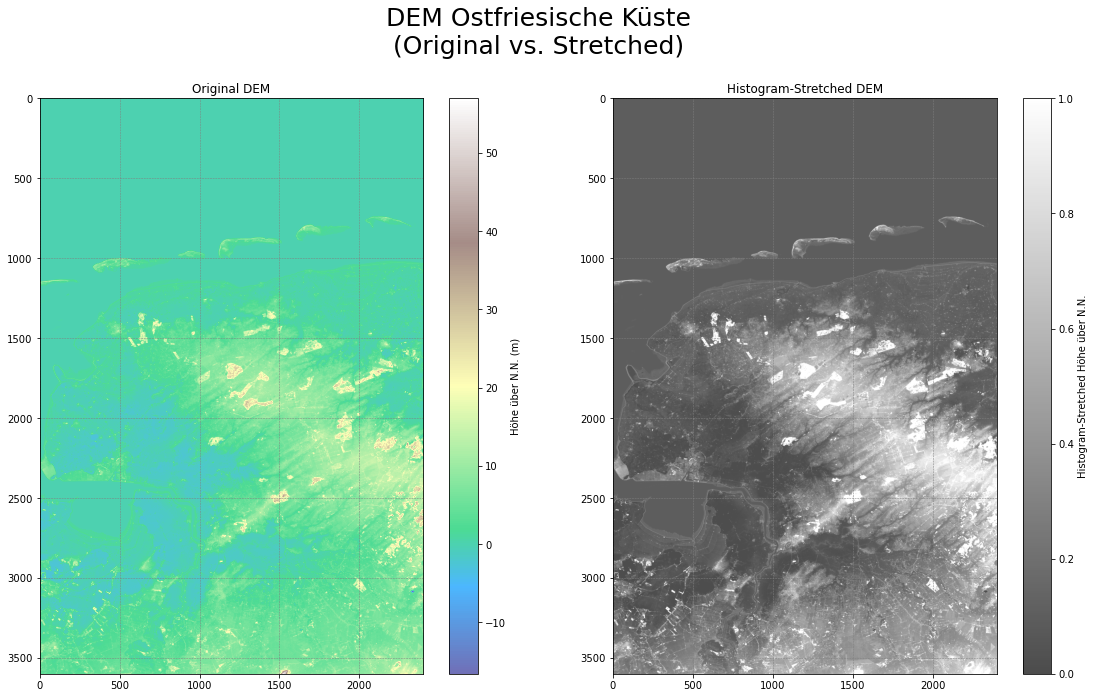

In [8]:
# DEM (Digitales Höhenmodell) laden
with rasterio.open(result[0]) as dataset:
    dem = dataset.read(1)  # Das erste Band (Höhenwerte) des DEM laden
    transform = dataset.transform  # Transformation des Koordinatensystems des DEM
    nodata = dataset.nodata  # NoData-Werte aus dem Dataset extrahieren
    
# NoData-Werte maskieren (ersetzen durch NaN)
dem = np.where(dem == nodata, np.nan, dem)

# Prozentränge auswählen, um extreme Werte zu begrenzen
p2, p98 = np.nanpercentile(dem, (2, 98))  # 2. und 98. Perzentil des DEM berechnen

# Lineares Strecken der DEM-Werte
dem_stretched = np.clip((dem - p2) / (p98 - p2), 0, 1)  # Strecken der Werte auf den Bereich [0, 1]

# Erstellen der Subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 10))  # Zwei Subplots nebeneinander

# Originales DEM plotten
im1 = axes[0].imshow(dem, cmap="terrain", alpha=0.7)  # Original DEM anzeigen mit Farbschema "terrain"
axes[0].set_title("Original DEM", fontsize=12)  # Titel für das erste Diagramm
axes[0].grid(True, color='gray', linestyle='--', linewidth=0.5)  # Gitterlinien hinzufügen

# Farbskala zum ersten Subplot hinzufügen
cbar1 = plt.colorbar(im1, ax=axes[0], orientation='vertical', label="Höhe über N.N. (m)")  # Vertikale Farbskala mit Bezeichnung

# Histogramm-strecktes DEM plotten
im2 = axes[1].imshow(dem_stretched, cmap="gray", alpha=0.7)  # Streckung des DEM anzeigen in Graustufen
axes[1].set_title("Histogram-Stretched DEM", fontsize=12)  # Titel für das zweite Diagramm
axes[1].grid(True, color='gray', linestyle='--', linewidth=0.5)  # Gitterlinien hinzufügen

# Farbskala zum zweiten Subplot hinzufügen
cbar2 = plt.colorbar(im2, ax=axes[1], orientation='vertical', label="Histogram-Stretched Höhe über N.N.")  # Vertikale Farbskala für das gestreckte DEM

# Optional: Einen allgemeinen Titel für das gesamte Diagramm hinzufügen
fig.suptitle("DEM Ostfriesische Küste\n(Original vs. Stretched)", fontsize=25, y=0.95)  # Gesamtüberschrift

# Layout anpassen, damit der Titel und die Subplots gut platziert sind
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Erhöht den Abstand oben, um Platz für die Gesamtüberschrift zu schaffen

# Das Diagramm anzeigen
plt.show()

#### 10. Öffnen des Ausschnitts

Aus ermittelten Werten für Norderney lässt sich der Ausschnitt als `window = (200, 800, 750, 500)` definieren. Wir zeigen den Ausschnitt auf dem Copernicus DEM (EEA-10)-Datensatz mit der kleineren Auflösung mit einem roten Kasten an (links). Rechts sehen wir dagegen nur den Ausschnitt von Norderney. Der kleinere Bildausschnitt der Anzeige rechts erlaubt uns nun auch die Original Höhenwerte zu nutzen bei gleichzeitig klaren Landschaftsstrukturen. Links verwenden wird nachwievor die ge-stretchten Pixelwerte.

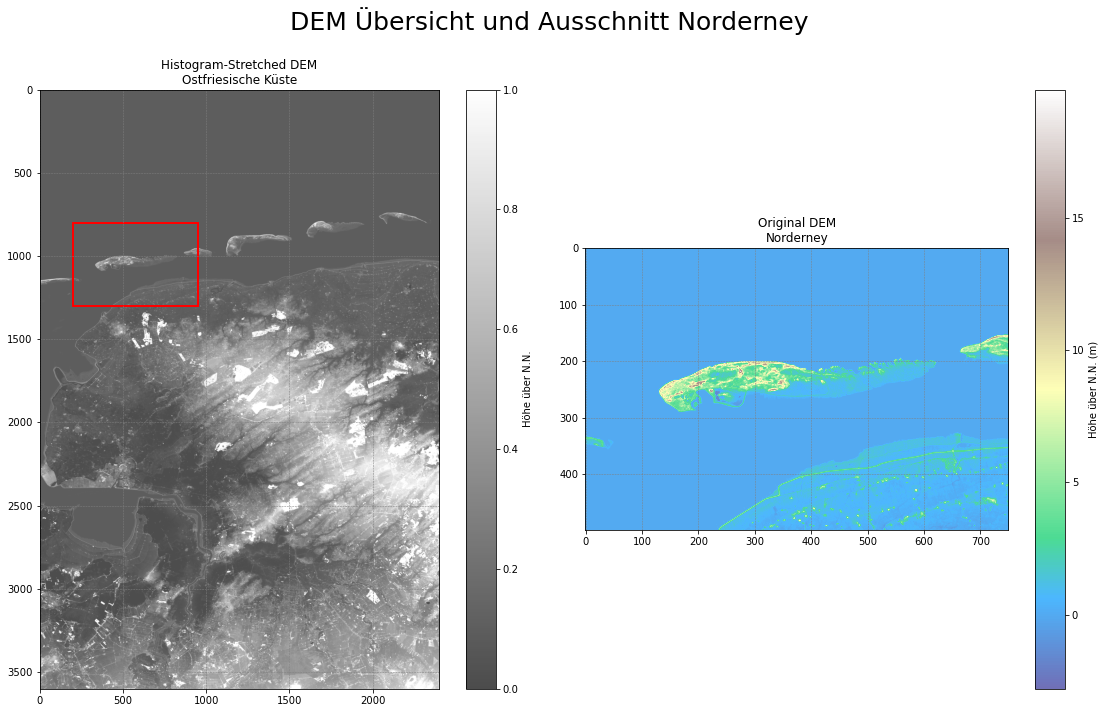

In [16]:
# Definieren des Ausschnittsfensters (Spaltenversatz, Zeilenversatz, Breite, Höhe)
window = (200, 800, 750, 500)  # (col_off, row_off, width, height)

# Entpacken des Fensters in einzelne Variablen
col_off, row_off, width, height = window

# Berechnen der Pixel-Koordinaten der Ecken des Fensters
corners_px = [
    (col_off, row_off),                       # obere linke Ecke
    (col_off + width, row_off),               # obere rechte Ecke
    (col_off + width, row_off + height),      # untere rechte Ecke
    (col_off, row_off + height),              # untere linke Ecke
    (col_off, row_off)                        # zurück zur oberen linken Ecke (um das Polygon zu schließen)
]

# Erstellen des Polygons (Ausschnittsfenster)
poly = Polygon(corners_px, closed=True, edgecolor='red', facecolor='none', linewidth=2)

# Laden des DEM
with rasterio.open(result[0]) as dataset:
    # Laden des DEM-Ausschnitts gemäß dem definierten Fenster
    dem_window = dataset.read(1, window=Window(col_off, row_off, width, height))
    transform = dataset.transform  # Transformation des Koordinatensystems
    nodata = dataset.nodata  # NoData-Werte des DEM
    
    # Maskieren der NoData-Werte (ersetzen durch NaN)
    dem_window = np.where(dem_window == nodata, np.nan, dem_window)

# Erstellen der Subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Plotten des gesamten gestreckten DEM
im1 = axes[0].imshow(dem_stretched, cmap="gray", alpha=0.7)  # Anzeige des gestreckten DEM
axes[0].grid(True, color='gray', linestyle='--', linewidth=0.5)  # Gitterlinien hinzufügen
axes[0].set_title("Histogram-Stretched DEM\nOstfriesische Küste", fontsize=12)  # Titel für das erste Diagramm
axes[0].add_patch(poly)  # Das Polygon zum ersten Plot hinzufügen (zeigt das Ausschnittsfenster)
cbar1 = plt.colorbar(im1, ax=axes[0], orientation='vertical', label="Höhe über N.N.")  # Farbskala hinzufügen

# Plotten des DEM für Norderney im definierten Ausschnitt
im2 = axes[1].imshow(dem_window, cmap="terrain", alpha=0.7)  # Anzeige des Ausschnitts von Norderney
axes[1].set_title("Original DEM\nNorderney", fontsize=12)  # Titel für das zweite Diagramm
axes[1].grid(True, color='gray', linestyle='--', linewidth=0.5)  # Gitterlinien hinzufügen
cbar1 = plt.colorbar(im2, ax=axes[1], orientation='vertical', label="Höhe über N.N. (m)")  # Farbskala für Norderney hinzufügen

# Optional: Einen allgemeinen Titel für das gesamte Diagramm hinzufügen
fig.suptitle("DEM Übersicht und Ausschnitt Norderney", fontsize=25, y=0.97)  # Gesamtüberschrift

# Layout anpassen, damit der Titel und die Subplots gut platziert sind
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Erhöht den Abstand oben, um Platz für die Gesamtüberschrift zu schaffen

# Das Diagramm anzeigen
plt.show()

#### 11.  Meeresspiegelsimulation

Durch den menschengemachten Klimawandel ist der Meeresspiegel bereits um 20cm angestiegen. Laut Prognose des IPCC hängt der zukünftige Anstieg des Meeresspiegels von den derzeitigen und zukünftigen globalen Treibhausgasemissionen ab. Die Emissionen bis 2100 sind dabei entscheidend, um Vorhersagen bis zum Jahr 2300 zu treffen (Abbildung 1a). Steigen die Temperaturen unter 1.5°C wird ein Meeresspiegelanstieg von 0.5m bis 3.2m für 2300 vorhergesagt (siehe Abbildung 1c). Im schlimmsten Fall, wenn die Emissionen nicht kontrolliert werden, steht ein Anstieg von 2m bis 7m bevor. Es kann auf Grund einer Vielzahl von Unsicherheiten ein Anstieg von 15m nicht ausgeschlossen werden.

<img src="https://www.geomar.de/fileadmin/_processed_/1/0/csm_IPCC_AR6_fig_SPM_8_62645245d8.png">

*Die Abbildungen wurden vom GEOMAR Helmholtz-Zentrum für Ozeanforschung Kiel (2025) auf der Grundlage des 6. Berichts des IPCC erstellt.*

Wir wollen uns eine Karte von Norderney anzeigen lassen, die die Überflutungsfläche bei einem Meeresspiegelanstieg darstellt. Die Karten bezieht Dämme und Deiche als Schutzwälle mit ein, mögliche Dammbrüche können jedoch nicht berechnet werden. 

Ausgehend von der oberen linken Ecke wird das gesammte Bild "überflutet". All Pixel die mit dem Pixel in der oberen linken Ecke verbunden sind werden konsekutiv als überflutet gelabeled und in der Karte blau angezeigt. Pixel, die unter der Flutschwelle von z.B. 0.2m oder 0.5m liegen, jedoch von einem Deich geschützt werden, werden dadurch ignoriert. 

Bis zu 3.2m Meeresspiegelanstieg bleibt das Festland größtenteils geschützt auf Grund der Deiche. Die Insel Norderney verliert maßgeblich an Fläche bei einem Anstieg von 2m Anstieg. Ab 7m Anstieg helfen die Deiche nicht und das Festland wird überflutet. Die Insel enthält Erhebungen von über 7m, die nicht geflutet würden. Ein Großteil der Insel wäre trotzdem überschwemmt. Bei 15m, im schlimmsten vom IPCC berechneten Fall bleibt keine Fläche übrig.

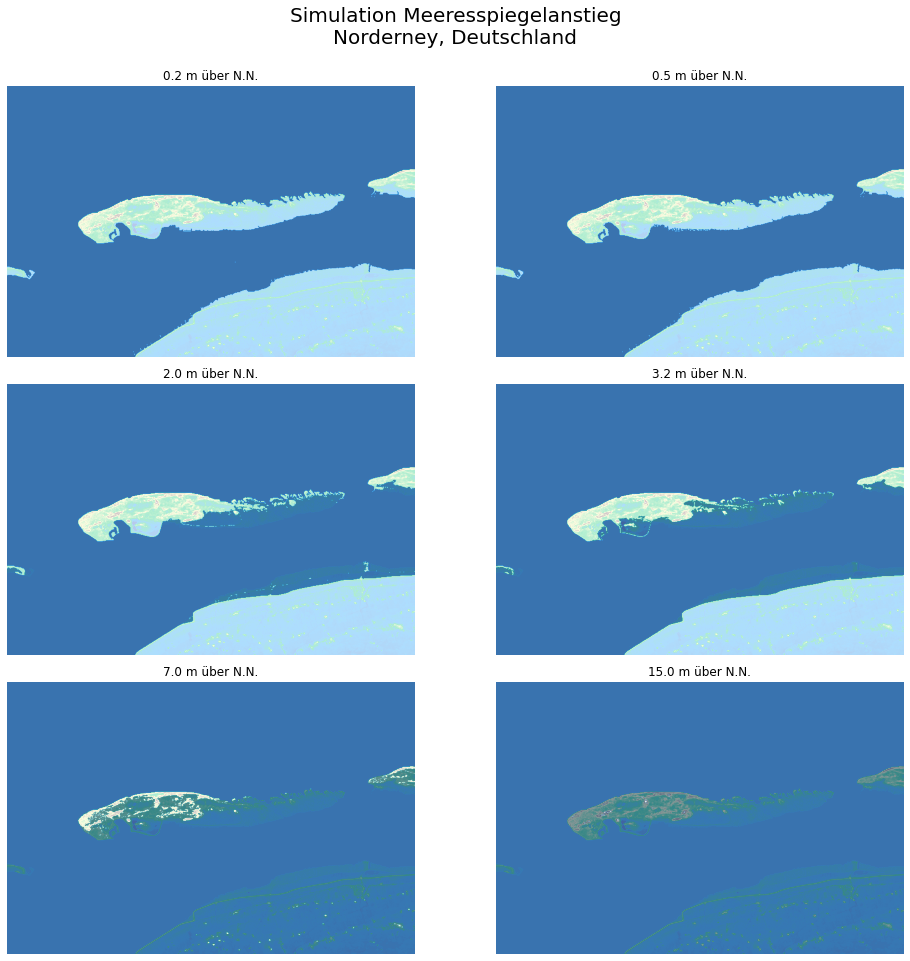

In [17]:
# Liste der Überflutungsstufen in Metern
flood_level_list = [0.20, 0.5, 2.00, 3.20, 7.00, 15.00]

# Erstellen einer Figur mit 3 horizontalen Subplots (2 Zeilen, 3 Spalten)
fig, axes = plt.subplots(3, 2, figsize=(14, 14))  # (Zeilen, Spalten)
axes = axes.flatten()  # Umwandeln der Achsen in ein flaches Array, um leichter darauf zugreifen zu können

# Schleife über jede Überflutungsstufe
for i, flood_level in enumerate(flood_level_list):

    # Identifizieren des anfänglichen Überflutungsbereichs (Gebiet, das unterhalb der Überflutungsstufe liegt)
    flood_mask = dem_window < flood_level

    # Setze Startpunkt (x=0, y=0) für die Flut
    seed = np.zeros_like(flood_mask, dtype=bool)
    seed[0, 0] = True  # Setze den Startpunkt in der oberen linken Ecke

    # Starte binäre Ausbreitung nur innerhalb der flood_mask, ausgehend vom Startpunkt
    flood_extent = binary_propagation(seed, mask=flood_mask)

    # Plotten auf der aktuellen Achse (Subplot)
    ax = axes[i]
    ax.imshow(dem_window, cmap="terrain", alpha=0.6)  # Anzeige des DEM mit Transparenz
    ax.imshow(flood_extent, cmap="Blues", alpha=0.5)  # Anzeige der überfluteten Gebiete
    ax.set_title(f"{str(flood_level)[0:4]} m über N.N.", fontsize=12)  # Titel für jede Stufe
    ax.axis("off")  # Optional: Entfernen der Achsenbeschriftungen

# Hinzufügen eines Titels für die gesamte Figur
fig.suptitle("Simulation Meeresspiegelanstieg\nNorderney, Deutschland", fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Genügend Platz für den Gesamttitel lassen
plt.show()  # Anzeige der Grafik